## 实验要求
### 截止日期：12月15日
作业的提交格式参考之前的说明，提交到18329300691@163.com
### 基本要求
a)	基于 Watermelon-train1数据集（只有离散属性），构造ID3决策树；
b)	基于构造的 ID3 决策树，对数据集 Watermelon-test1进行预测，输出分类精度；



#### 导入所需的包

In [2]:
import numpy as np
import operator
import math
import pandas as pd

#### 导入数据集

In [3]:

def GetData_watermelon():
    path = "Watermelon-train1.csv"
    data = pd.read_csv(path, header=None, names=["色泽", "根蒂","敲声","纹理","label"], encoding='gbk')
    clos = data.shape[1]  # 获取列数
    all_data = data.iloc[:, 0:clos]
    all_data = np.delete(np.array(all_data), 0, axis=0)  # 删除首行
    labels = data.columns.tolist()
    labels.pop()
    trainDataSet = np.array(all_data)  # 选取了一部分作为训练集
    
    path = "Watermelon-test1.csv"
    data = pd.read_csv(path, header=None, names=["色泽", "根蒂","敲声","纹理","label"], encoding='gbk')
    clos = data.shape[1]  # 获取列数
    new_data = data.iloc[:, 0:clos]
    new_data = np.delete(np.array(all_data), 0, axis=0)  # 删除首行
    labels = data.columns.tolist()
    labels.pop()
    testDataSet = np.array(new_data)  # 得到训练数据集
 
    return trainDataSet, testDataSet, np.array(labels)

#### 计算数据集信息熵

In [4]:
def dataset_entropy(dataset):
    classLabel = dataset[:, -1] # 标签
    labelCount = {}
    for i in range(classLabel.size):
        label = classLabel[i]
        labelCount[label] = labelCount.get(label, 0) + 1
    # 熵值(第一步)
    cnt = 0
    for k, v in labelCount.items():
        cnt += -v / classLabel.size * np.log2(v / classLabel.size)
    return cnt
 
    # 接下来切分,然后算最优属性

#### 根据给定的特征索引分割数据集

In [5]:
def splitDataSet(dataset, featureIndex):
    subdataset = []
    featureValues = dataset[:, featureIndex]
    featureSet = list(set(featureValues))
    for i in range(len(featureSet)):
        newset = []
        for j in range(dataset.shape[0]):
            if featureSet[i] == featureValues[j]:
                newset.append(dataset[j, :])
        newset = np.delete(newset, featureIndex, axis=1)
        subdataset.append(np.array(newset))
    return subdataset

In [6]:
def splitDataSetByValue(dataset, featureIndex, value):
    subdataset = []
    for example in dataset:
        if example[featureIndex] == value:
            subdataset.append(example)
    if not subdataset:
        return subdataset
    return np.delete(subdataset, featureIndex, axis=1)

#### 选择最佳特征，使用信息增益度量

In [7]:
def chooseBestFeature(dataset, labels):
    featureNum = labels.size
    minEntropy, bestFeatureIndex = 1, None
    n = dataset.shape[0]
    for i in range(featureNum):
        featureEntropy = 0
        allSubDataSet = splitDataSet(dataset, i)
        for subDataSet in allSubDataSet:
            featureEntropy += subDataSet.shape[0] / n * dataset_entropy(subDataSet)
        if minEntropy > featureEntropy:
            minEntropy = featureEntropy
            bestFeatureIndex = i
    return bestFeatureIndex

#### 返回类别列表中出现最多的类别

In [8]:
def mayorClass(classList):
    labelCount = {}
    for i in range(classList.size):
        label = classList[i]
        labelCount[label] = labelCount.get(label, 0) + 1
    sortedLabel = sorted(labelCount.items(), key=operator.itemgetter(1), reverse=True)
    return sortedLabel[0][0]

#### 构建决策树

In [9]:
def createID3(dataset, labels):
    # 创建ID3决策树
    classList = dataset[:, -1]
    if len(set(dataset[:, -1])) == 1:
        return dataset[:, -1][0]
    if labels.size == 0 or len(dataset[0]) == 1:
        return mayorClass(classList)
    bestFeatureIndex = chooseBestFeature(dataset, labels)
    bestFeature = labels[bestFeatureIndex]
    dtree = {bestFeature: {}}
    featureList = dataset[:, bestFeatureIndex]
    featureValues = set(featureList)
    for value in featureValues:
        subdataset = splitDataSetByValue(dataset, bestFeatureIndex, value)
        sublabels = np.delete(labels, bestFeatureIndex)
        dtree[bestFeature][value] = createID3(subdataset, sublabels)
    return dtree

#### 使用训练好的决策树进行预测

In [10]:
def predict_class(inputTree, featLabels, testVec):
    firstStr = list(inputTree.keys())[0]
    secondDict = inputTree[firstStr]
    classlabel = None
    featIndex = featLabels.index(firstStr)
    for key in secondDict.keys():
        if testVec[featIndex] == int(key):
            if type(secondDict[key]).__name__ == 'dict':
                classlabel = predict_class(secondDict[key], featLabels, testVec)
            else:
                classlabel = secondDict[key]
    return classlabel

def calculate_accuracy(tree, labels, test_data):
    correct_count = 0
    for test_instance in test_data:
        predicted_class = predict_class(tree, labels, test_instance)
        if predicted_class == test_instance[-1]:
            correct_count += 1
    accuracy = correct_count / len(test_data)
    return accuracy


#### 对树进行可视化

In [11]:
import matplotlib.pyplot as plt 

decisionNodeStyle = dict(boxstyle = "round4", fc = "1")
leafNodeStyle = {"boxstyle": "round4", "fc": "1"}
arrowArgs = {"arrowstyle": "<-"}

def getTreeSize(decisionTree):
    nodeName = list(decisionTree.keys())[0]
    nodeValue = decisionTree[nodeName]
    leafNum = 0
    treeDepth = 0 
    leafDepth = 0
    for val in nodeValue.keys():
        if type(nodeValue[val]) == dict:
            leafNum += getTreeSize(nodeValue[val])[0]
            leafDepth = 1 + getTreeSize(nodeValue[val])[1] 
        else :
            leafNum += 1 
            leafDepth = 1 
        treeDepth = max(treeDepth, leafDepth)
    return leafNum, treeDepth 

# 画节点
def plotNode(nodeText, centerPt, parentPt, nodeStyle):
    createPlot.ax1.annotate(nodeText, xy = parentPt, xycoords = "axes fraction", xytext = centerPt
                            , textcoords = "axes fraction", va = "center", ha="center", bbox = nodeStyle, arrowprops = arrowArgs)


# 添加箭头上的标注文字
def plotMidText(centerPt, parentPt, lineText):
    xMid = (centerPt[0] + parentPt[0]) / 2.0
    yMid = (centerPt[1] + parentPt[1]) / 2.0 
    createPlot.ax1.text(xMid, yMid, lineText)
    
    
# 画树
def plotTree(decisionTree, parentPt, parentValue):
    # 计算宽与高
    leafNum, treeDepth = getTreeSize(decisionTree) 
    # 在 1 * 1 的范围内画图，因此分母为 1
    # 每个叶节点之间的偏移量
    plotTree.xOff = plotTree.figSize / (plotTree.totalLeaf - 1)
    # 每一层的高度偏移量
    plotTree.yOff = plotTree.figSize / plotTree.totalDepth
    # 节点名称
    nodeName = list(decisionTree.keys())[0]
    # 根节点的起止点相同，可避免画线；如果是中间节点，则从当前叶节点的位置开始，
    #      然后加上本次子树的宽度的一半，则为决策节点的横向位置
    centerPt = (plotTree.x + (leafNum - 1) * plotTree.xOff / 2.0, plotTree.y)
    # 画出该决策节点
    plotNode(nodeName, centerPt, parentPt, decisionNodeStyle)
    # 标记本节点对应父节点的属性值
    plotMidText(centerPt, parentPt, parentValue)
    # 取本节点的属性值
    treeValue = decisionTree[nodeName]
    # 下一层各节点的高度
    plotTree.y = plotTree.y - plotTree.yOff
    # 绘制下一层
    for val in treeValue.keys():
        # 如果属性值对应的是字典，说明是子树，进行递归调用； 否则则为叶子节点
        if type(treeValue[val]) == dict:
            plotTree(treeValue[val], centerPt, str(val))
        else:
            plotNode(treeValue[val], (plotTree.x, plotTree.y), centerPt, leafNodeStyle)
            plotMidText((plotTree.x, plotTree.y), centerPt, str(val))
            # 移到下一个叶子节点
            plotTree.x = plotTree.x + plotTree.xOff
    # 递归完成后返回上一层
    plotTree.y = plotTree.y + plotTree.yOff
    
    
# 画出决策树
def createPlot(decisionTree):
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文显示
    plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
    fig = plt.figure(1, facecolor = "white")
    fig.clf()
    axprops = {"xticks": [], "yticks": []}
    createPlot.ax1 = plt.subplot(111, frameon = False, **axprops)
    # 定义画图的图形尺寸
    plotTree.figSize = 1.5 
    # 初始化树的总大小
    plotTree.totalLeaf, plotTree.totalDepth = getTreeSize(decisionTree)
    # 叶子节点的初始位置x 和 根节点的初始层高度y
    plotTree.x = 0 
    plotTree.y = plotTree.figSize
    plotTree(decisionTree, (plotTree.figSize / 2.0, plotTree.y), "")
    plt.show()


#### 画出决策树，对测试集进行测试

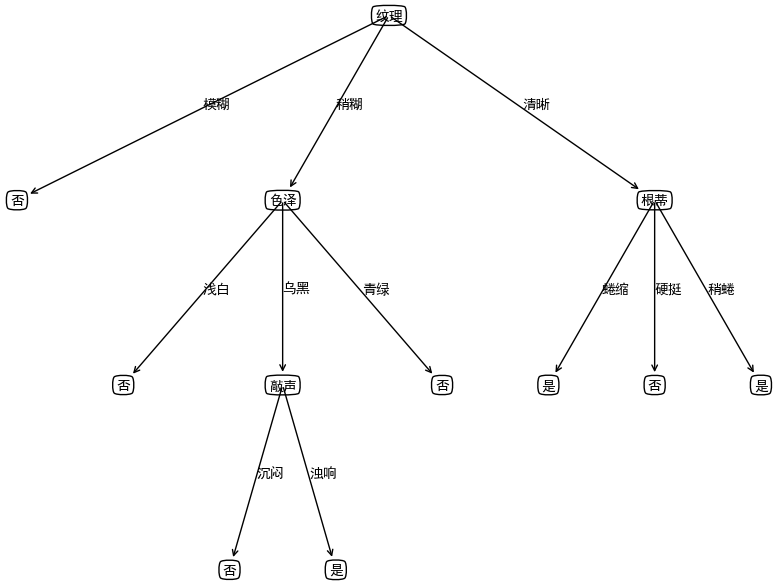

AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [14]:
dataset, testdata, labels = GetData_watermelon()
mytree = createID3(dataset, labels)
createPlot(mytree)
calculate_accuracy(mytree, labels, testdata)

### 中级要求
a)  对数据集Watermelon-train2，构造C4.5或者CART决策树，要求可以处理连续型属性；
b)	对测试集Watermelon-test2进行预测，输出分类精度；

CART决策树与ID3决策树主要的区别就是判断依据为基尼系数，而不是信息熵。

#### 导入含连续性属性的数据集2

In [ ]:
def GetData_watermelon2():
    path = "Watermelon-train2.csv"
    data = pd.read_csv(path, header=None, names=["色泽", "根蒂","敲声","纹理","密度","label"], encoding='gbk')
    clos = data.shape[1]  # 获取列数
    all_data = data.iloc[:, 0:clos]
    all_data = np.delete(np.array(all_data), 0, axis=0)  # 删除首行
    labels = data.columns.tolist()
    labels.pop()
    
    # 为处理连续型属性，将"密度"列内容根据是否大于平均值改为'大'和'小'
    mean_density = np.mean(all_data[:, -2].astype(float))
    all_data[:, -2] = np.where(all_data[:, -2].astype(float) > mean_density, '大', '小')
    
    trainDataSet2 = np.array(all_data)  # 训练集
    
    path = "Watermelon-test2.csv"
    data = pd.read_csv(path, header=None, names=["色泽", "根蒂","敲声","纹理","密度","label"], encoding='gbk')
    clos = data.shape[1]  # 获取列数
    new_data = data.iloc[:, 0:clos]
    new_data = np.delete(np.array(new_data), 0, axis=0)  # 删除首行
    labels = data.columns.tolist()
    labels.pop()
    
    new_data[:, -2] = np.where(new_data[:, -2].astype(float) > mean_density, '大', '小')
    
    testDataSet2 = np.array(new_data)  # 测试集
 
    return trainDataSet2, testDataSet2, np.array(labels)


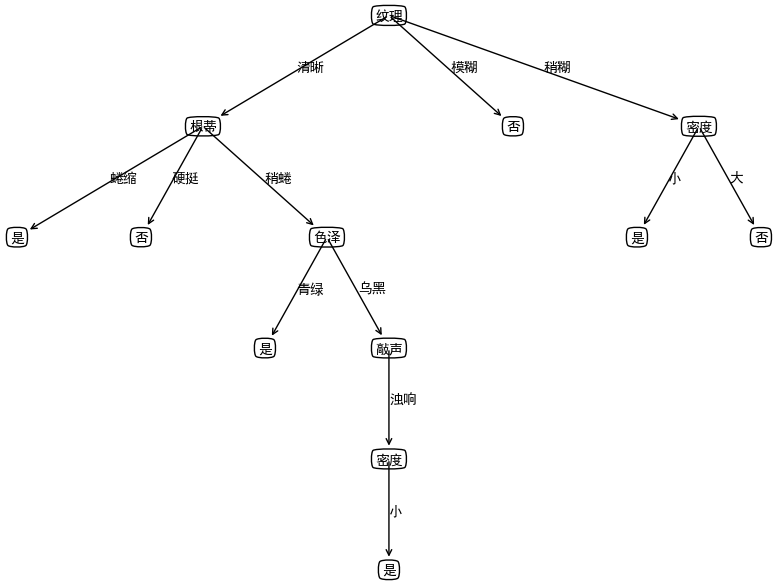

In [ ]:
# 计算基尼系数
def dataset_gini(dataset): 
    classLabel = dataset[:, -1]
    labelCount = {}
    for i in range(classLabel.size):
        label = classLabel[i]
        labelCount[label] = labelCount.get(label, 0) + 1
    Gini = 1.0
    for k, v in labelCount.items():
        Gini -= float(v / classLabel.size) * float(v / classLabel.size)
    return Gini


def chooseBestGiniFeature(dataset, labels):
    featureNum = labels.size
    minEntropy, bestFeatureIndex = 1, None
    n = dataset.shape[0]
    for i in range(featureNum):
        featureEntropy = 0
        allSubDataSet = splitDataSet(dataset, i)
        for subDataSet in allSubDataSet:
            featureEntropy += subDataSet.shape[0] / n * dataset_gini(subDataSet)
        if minEntropy > featureEntropy:
            minEntropy = featureEntropy
            bestFeatureIndex = i
    return bestFeatureIndex

def createCART(dataset, labels):
    classList = dataset[:, -1]
    if len(set(dataset[:, -1])) == 1:
        return dataset[:, -1][0]
    if labels.size == 0 or len(dataset[0]) == 1:
        return mayorClass(classList)
    bestFeatureIndex = chooseBestGiniFeature(dataset, labels)
    bestFeature = labels[bestFeatureIndex]
    dtree = {bestFeature: {}}
    featureList = dataset[:, bestFeatureIndex]
    featureValues = set(featureList)
    for value in featureValues:
        subdataset = splitDataSetByValue(dataset, bestFeatureIndex, value)
        sublabels = np.delete(labels, bestFeatureIndex)
        dtree[bestFeature][value] = createCART(subdataset, sublabels)
    return dtree

dataset2, testdata2, labels2 = GetData_watermelon2()
CARTtree = createCART(dataset2, labels2)
createPlot(CARTtree)



### 高级要求
使用任意的剪枝算法对构造的决策树（基本要求和中级要求构造的树）进行剪枝，观察测试集合的分类精度是否有提升，给出分析过程。

#### 预剪枝

In [ ]:
def cntAccNums(dataSet, pruneSet):
    nodeClass = mayorClass(dataSet[:, -1])
    rightCnt = 0
    for vect in pruneSet:
        if vect[-1] == nodeClass:
            rightCnt += 1
    return rightCnt
 
def prePruning(dataSet, pruneSet, labels):
 
    classList = dataSet[:, -1]
 
    if len(set(classList)) == 1:
        return classList[0]
 
    if len(dataSet[0]) == 1:
        return mayorClass(classList)
 
    # 获取最好特征
    bestFeat = chooseBestGiniFeature(dataSet, labels) # √
    bestFeatLabel = labels[bestFeat] # 获取特征名称
    sublabels = np.delete(labels, bestFeat) # 从特征名列表删除
    # 计算初始正确率
    baseRightNums = cntAccNums(dataSet, pruneSet)
    # 得到最好划分属性取值
    featureList = dataSet[:, bestFeat]  # 最佳的特征列也选出来了
    features = set(featureList) # 取出特征下的属性集合
    # 计算尝试划分节点时的正确率
    splitRightNums = 0.0
    for value in features: # 遍历每一个属性
        # 每个属性取值得到的子集
        subDataSet = splitDataSetByValue(dataSet, bestFeat, value)
        if len(subDataSet) != 0:
            # 把用来剪枝的子集也按照相应属性值划分下去
            subPruneSet = splitDataSetByValue(pruneSet, bestFeat, value)
            # if value == "凹陷":
            #     print(subPruneSet)
            splitRightNums += cntAccNums(subDataSet, subPruneSet)
    if baseRightNums < splitRightNums:  # 如果不划分的正确点数少于尝试划分的点数，则继续划分。
        myTree = {bestFeatLabel: {}}
    else:
        return mayorClass(dataSet[:, -1])  # 否则，返回不划分时投票得到的类
 
    # 以下代码和不预剪枝的代码大致相同，一点不同在于每次测试集也要参与划分。
    for value in features:
        subDataSet = splitDataSetByValue(dataSet, bestFeat, value)
        subPruneSet = splitDataSetByValue(pruneSet, bestFeat, value)
        if len(subDataSet) != 0:
            myTree[bestFeatLabel][value] = prePruning(subDataSet, subPruneSet, sublabels)
        else:
            # 计算D中样本最多的类
            myTree[bestFeatLabel][value] = mayorClass(classList)
    return myTree

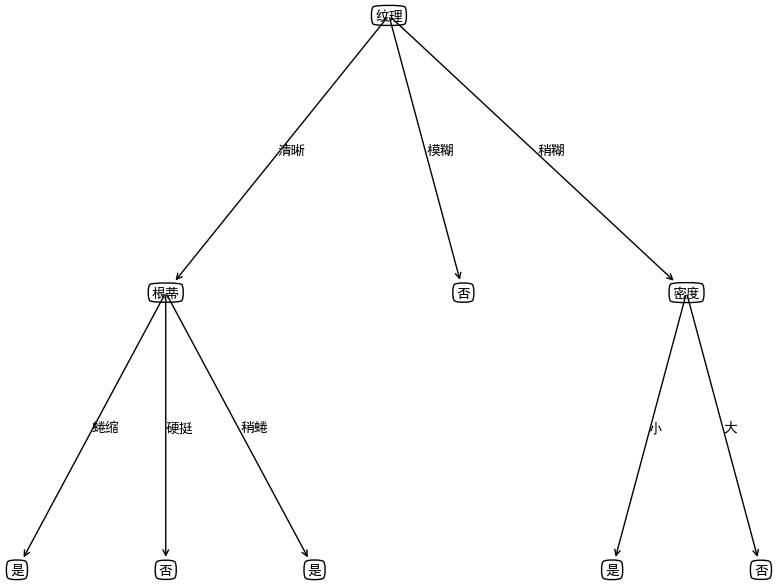

In [ ]:
dataset2, testdata2, labels2 = GetData_watermelon2()

preTree = prePruning(dataset2, testdata2, labels2)
createPlot(preTree)

#### 后剪枝

In [ ]:
def postPruning(dataSet, pruneSet, labels):
    classList = dataSet[:, -1]
    # 如果基尼指数为0，即D中样本全属于同一类别，返回
    if len(set(classList)) == 1:
        return classList[0]
    # 属性值为空，只剩下类标签
    if len(dataSet[0]) == 1:
        return mayorClass(classList)
 
    # 得到增益最大划分的属性、值
    bestFeat = chooseBestFeature(dataSet, labels)
    bestFeatLabel = labels[bestFeat]
    myTree = {bestFeatLabel: {}}  # 创建字典，即树的节点。
    # 生成子树的时候要将已遍历的属性删去。数值型不要删除。
    sublabels = np.delete(labels, bestFeat)
    featureList = dataSet[:, bestFeat]  # 最佳的特征列也选出来了
    uniqueVals = set(featureList) # 取出特征下的属性集合
    for value in uniqueVals:  # 标称型的属性值有几种，就要几个子树。
        # Python中列表作为参数类型时，是按照引用传递的，要保证同一节点的子节点能有相同的参数。
        subPrune = splitDataSetByValue(pruneSet, bestFeat, value)
        subDataSet = splitDataSetByValue(dataSet, bestFeat, value)
        if len(subDataSet) != 0:
            myTree[bestFeatLabel][value] = postPruning(subDataSet, subPrune, sublabels)
        else:
            # 计算D中样本最多的类
            myTree[bestFeatLabel][value] = mayorClass(classList)
 
    # 后剪枝，如果到达叶子节点，尝试剪枝。
    # 计算未剪枝时，测试集的正确数
    numNoPrune = 0.0
    for value in uniqueVals:
        subDataSet = splitDataSetByValue(dataSet, bestFeat, value)
        if len(subDataSet) != 0:
            subPrune = splitDataSetByValue(pruneSet, bestFeat, value)
            numNoPrune += cntAccNums(subDataSet, subPrune)
    # 计算剪枝后，测试集正确数
    numPrune = cntAccNums(dataSet, pruneSet)
    # 比较决定是否剪枝, 如果剪枝后该节点上测试集的正确数变多了，则剪枝。
    if numNoPrune < numPrune:
        return mayorClass(dataSet[:, -1])  # 直接返回节点上训练数据的多数类为节点类。
 
    return myTree

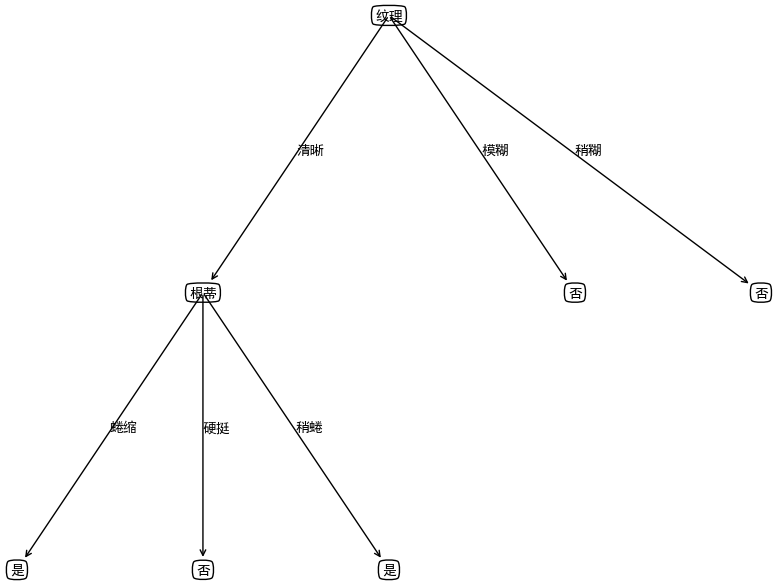

In [ ]:
preTree = prePruning(dataset2, testdata, labels2)
createPlot(preTree)

## 什么是决策树
<img src="https://s2.loli.net/2022/10/23/yTpSLmgFWOh4Y5d.png" style="zoom:66%" align="left"/>

## 决策树的划分
- 决策树主要分为三种：
	ID3，C4.5和CART，它们分别对应的**特征选择准则**是信息增益（ID3），信息增益比（C4.5）和基尼指数（CART）。
	它们决定当前选择哪个特征进行数据划分，使得样本在当下能够被最大程度的划分。
- 对于离散变量，选定**属性**分类即可；
- 对于连续变量，需要选定**划分点**。
- CART和C4.5支持数据特征为**连续分布**时的处理，能够完成对连续属性的离散化处理，主要通过二元切分的方式来处理连续型变量，这个分裂点的选择原则是使得划分后的子树中的“混乱程度”降低。

## ID3算法
- ID3算法的核⼼思想应用信息增益准则作为标准,介绍信息增益之前首先介绍一下信息熵和条件熵： 
- 熵（entropy）概念：
	    1948年，香农提出了“信息熵”的概念。在信息论与概率统计中，熵是表示随机变量不确定性的量。X是⼀个取值为有限个的离散随机变量，
$$ H(X)=-\sum_{i=1}^{n} p\left(x_{i}\right) \log p\left(x_{i}\right)$$ 
$𝐻(𝑋)$就被称作随机变量𝑋的熵，它表示随机变量不确定的度量。熵取值越大，随机变量不确定性越大。当随机变量为均匀分布时，熵最大。当某一状态概率取值为1时，熵的值为零。

### ID3算法-条件熵和信息增益
- 条件熵 $𝐻(𝑌∣𝑋)$ ：
	表示在已知随机变量𝑋的条件下随机变量𝑌的不确定性，定义为给定𝑋条件下𝑌的条件概率分布的熵对𝑋的数学期望:
$$H(Y \mid X)=\sum_{x} p(x) H(Y \mid X=x) =-\sum_{x} p(x) \sum_{y} p(y \mid x) \log p(y \mid x)$$

- 特征𝐴对数据集𝐷的信息增益就是熵$𝐻(𝐷)$与条件熵$𝐻(𝐷|𝐴)$之差:
$$𝐻(𝐷)−𝐻(𝐷∣𝐴)$$

	表示已知特征𝐴的信息而使得数据集𝐷的信息不确定减少的程度。信息增益越大的特征代表其具有更强的分类能力，所以我们就要**选择能够使数据的不确定程度减少最多的特征**，也就是信息增益最大的特征。

### ID3算法-停止条件
- 决策树的生成:

	从根节点开始，计算所有可能特征的信息增益，选择信息增益最大的特征作为划分该节点的特征，根据该特征的不同取值建立子节点；
	在对子节点递归地调用以上方法，直到达到停止条件，得到⼀个决策树。
    
    
- 迭代停止条件：
  1. 当前结点所有样本都属于同⼀类别；
  2. 当前结点的所有属性值都相同，没有剩余属性可用来进一步划分样本；
  3. 达到最大树深；
  4. 达到叶子结点的最小样本数；

### ID3算法举例

<img src="https://s2.loli.net/2022/10/23/p7gSQeYGnoBCd2i.png" style="zoom:64%" />


$$
\begin{array}{l}
\operatorname{Info}^{\text {In }}(D)=-\frac{9}{14} \log _{2}\left(\frac{9}{14}\right)-\frac{5}{14} \log _{2}\left(\frac{5}{14}\right)=0.940 \\
\operatorname{Infoage~}(D)=\frac{5}{14} \times\left(-\frac{2}{5} \times \log _{2} \frac{2}{5}-\frac{3}{5} \times \log _{2} \frac{3}{5}\right)+\frac{4}{14} \times\left(-\frac{4}{4} \times \log _{2} \frac{4}{4}-\frac{0}{4} \times \log _{2} \frac{0}{4}\right) 
+\frac{5}{14} \times\left(-\frac{2}{5} \times \log _{2} \frac{2}{5}-\frac{3}{5} \times \log _{2} \frac{3}{5}\right)=0.694 \\
\text { Gain }(\text { age })=\operatorname{Info}(D)-\operatorname{InfO}_{\text {age }}(D) =0.940-0.694=0.246
\end{array}
$$

<img src="https://s2.loli.net/2022/10/23/1zAnHWKRgQ9FaJV.png" style="zoom:72%" />
类似地，
Gain(income)=0.029    
Gain(student)=0.151    
Gain(credit_rating)=0.048

所以，选择age作为第一个根节点

## C4.5算法
- C4.5算法与ID3算法相似，其对ID3算法进行了改进。
- 信息增益作为划分准则存在的问题：

     信息增益偏向于选择取值较多的特征进行划分。⽐如学号这个特征，每个学生都有一个不同的学号，如果根据学号对样本进行分类，则每个学生都属于不同的类别，这样是没有意义的。而C4.5在生成过程中，用**信息增益比**来选择特征，可以校正这个问题。
     
- 特点
  - 能够完成对连续属性的离散化处理
  - 能够对不完整数据进行处理
  - 需要对数据集进行多次的顺序扫描和排序

## CART算法
- ID3和C4.5虽然在对训练样本集的学习中可以尽可能多的挖掘信息，但其生成的决策树分支较大，规模较大。为了简化决策树的规模，提高生成决策树的效率，就出现了根据**基尼指数**来选择的CART； 
- 对于给定的样本集合 ，其基尼指数为： $$ {Gini}(D)=1-\sum_{k=1}^{K}\left(\frac{\left|C_{k}\right|}{|D|}\right)^{2} $$
   其中$𝐶_𝑘$是𝐷中属于第𝑘类的样本子集，K是类的个数。
- 基尼系数的性质与信息熵一样：
   度量随机变量的不确定度的大小；基尼指数越⼩表示数据的纯度越高，反之其值越大，样本集合的不确定性也就越大。

## 决策树的剪枝
- 决策树很容易出现**过拟合现象**。原因在于学习时完全考虑的是如何提⾼对训练数据的正确分类从⽽构建出过于复杂的决策树。
- 解决这个问题的方法称为**剪枝**，即对已生成的树进行简化。具体地，就是从已生成的树上裁剪掉⼀些子树或叶节点，并将其根节点或父节点作为新的叶节点。 
- 决策树的剪枝基本策略有**预剪枝 (Pre-Pruning)** 和 **后剪枝 (Post-Pruning)**
   - **预剪枝**：是根据⼀些原则**极早的停止树增长**，如树的深度达到用户所要的深度、节点中样本个数少于用户指定个数、不纯度指标下降的幅度小于用户指定的幅度等。 
   - **后剪枝**：是通过在完全生长的树上剪去分枝实现的，通过删除节点的分支来剪去树节点。是在生成决策树之后**自底向上**的对树中所有的非叶结点进⾏逐一考察 。